In [1]:
%matplotlib inline

This example follows Torch's [transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). We will

1. Finetune a pretrained convolutional neurel network on a specific task (ants vs. bees).
2. Use a Dask cluster for batch prediction with that model.

The primary focus is using a Dask cluster for batch prediction.

Note that the base environment on the examples.dask.org Binder does not include PyTorch
or torchvision. To run this example, you'll need to run

```
!conda install -y pytorch-cpu torchvision
```

which will take a bit of time to run.

## Download the data

The PyTorch documentation hosts a small set of data. We'll download and extract it locally.

In [2]:
import urllib.request
import zipfile

In [3]:
filename, _ = urllib.request.urlretrieve("https://download.pytorch.org/tutorial/hymenoptera_data.zip", "data.zip")
zipfile.ZipFile(filename).extractall()

The directory looks like

```
hymenoptera_data/
    train/
        ants/
            0013035.jpg
            ...
            1030023514_aad5c608f9.jpg
        bees/
            1092977343_cb42b38d62.jpg
            ...
            2486729079_62df0920be.jpg
     
    train/
        ants/
            0013025.jpg
            ...
            1030023514_aad5c606d9.jpg
        bees/
            1092977343_cb42b38e62.jpg
            ...
            2486729079_62df0921be.jpg
  
```

Following the [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), we'll finetune the model.

In [5]:
import torchvision
from tutorial_helper import (imshow, train_model, visualize_model,
                             dataloaders, class_names, finetune_model)

## Finetune the model

Our base model is resnet18. It predicts for 1,000 categories, while ours just predicts 2 (ants or bees). To make this model train quickly on examples.dask.org, we'll only use a couple of epochs.

In [6]:
%%time
model = finetune_model()
type(model)

Epoch 0/1
----------
train Loss: 0.5775 Acc: 0.7090
val Loss: 0.2725 Acc: 0.9085

Epoch 1/1
----------
train Loss: 0.5279 Acc: 0.7377
val Loss: 0.3346 Acc: 0.8824

Training complete in 0m 52s
Best val Acc: 0.908497
CPU times: user 3min 54s, sys: 2min 32s, total: 6min 27s
Wall time: 52.7 s


torchvision.models.resnet.ResNet

Things seem OK on a few random images:

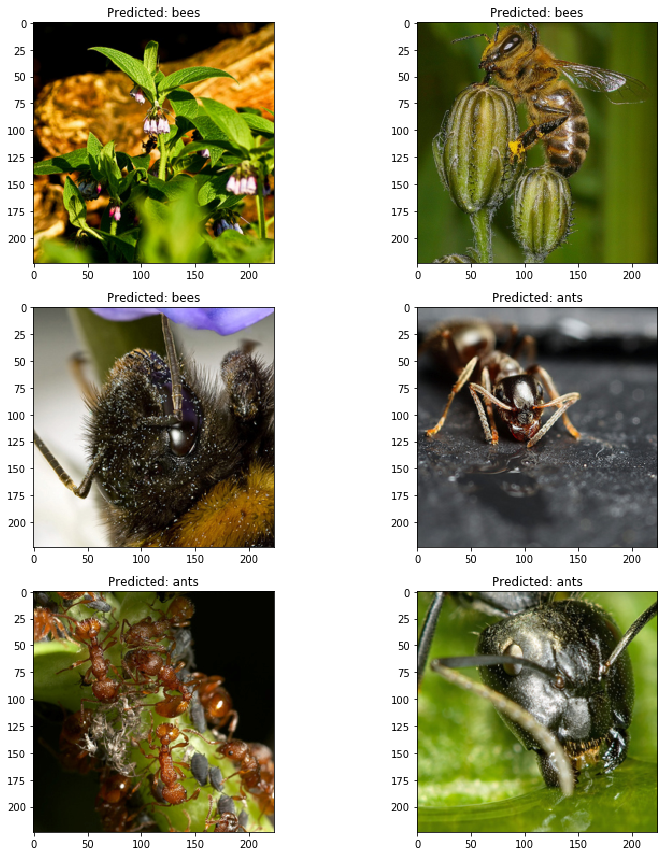

In [7]:
visualize_model(model);

## Batch Prediction with Dask

Now for the main topic: using a pretrained model for batch prediction on a Dask cluster.
There are two main complications, that both deal with minimizing the amount of data
moved around:

1. **Loading the data on the workers.**. We'll use `dask.delayed` to load the data on
   the workers, rather than loading it on the client and sending it to the workers.
2. **PyTorch neurel networks are large.** We don't want them in Dask task graphs, and we
   only want to move them around once.

In [8]:
from distributed import Client

client = Client(n_workers=2, threads_per_worker=2)
client

Client Scheduler: tcp://127.0.0.1:34537 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 31.62 GB


### Loading the data on the workers

First, we'll define a couple helpers to load the data and preprocess it for the network.
We'll use `dask.delayed` here so that the execuation is lazy and happens on the cluster.
See [the delayed example](../delayed.ipynb) for more on using `dask.delayed`.

In [9]:
import glob
import toolz
import dask
import dask.array as da
import torch
from torchvision import transforms
from PIL import Image


@dask.delayed
def load(path, fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img


@dask.delayed
def transform(img):
    trn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return trn(img)


def batch(*arrs):
    return torch.stack(arrs)

In [10]:
objs = [load(x) for x in glob.glob("hymenoptera_data/val/*/*.jpg")]

To load the data from cloud storage, say Amazon S3, you would use

```python
fs = s3fs.S3FileSystem(...)
objs = [load(x, fs=fs) for x in fs.glob(...)]
```

The PyTorch model expects tensors of a specific shape, so let's
transform them.

In [11]:
tensors = [transform(x) for x in objs]

And the model expects batches of inputs, so let's stack a few together.

In [12]:
batches = [dask.delayed(torch.stack)(batch) for batch in toolz.partition_all(10, tensors)]
batches[:5]

[Delayed('stack-faba395f-411e-4092-b68e-2acf2c389a8e'),
 Delayed('stack-c0b45c78-1758-4fb5-8eee-87b3e4e2c955'),
 Delayed('stack-ce91118b-7db4-4bdc-92da-6386592febfc'),
 Delayed('stack-cb6a1dc4-62c4-48ab-8069-3689653489bd'),
 Delayed('stack-b12d8fc0-1ea1-4e7c-88ee-a2599dcdc806')]

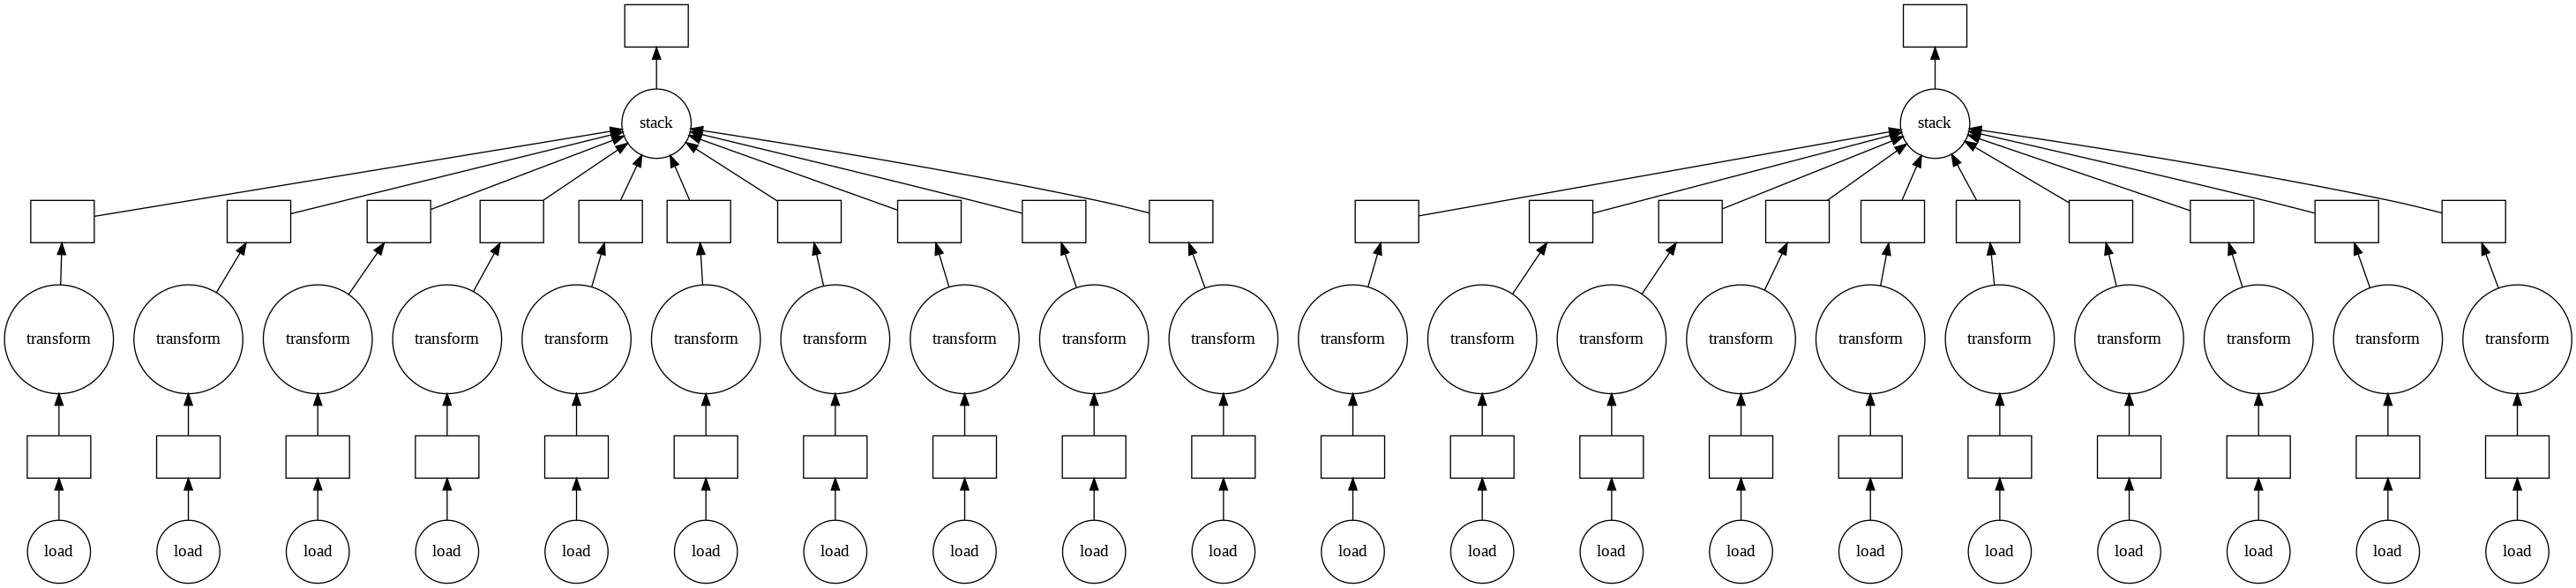

In [13]:
dask.visualize(batches[:2])

Finally, we'll write a small `predict` helper.

In [14]:
def predict(batch, model):
    batch, = dask.compute(batch)

    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

We can try one out locally.

In [15]:
predictions = predict(batches[0], model)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

Which corresponds to the following labels:

In [16]:
[class_names[x] for x in predictions]

['ants',
 'ants',
 'ants',
 'ants',
 'ants',
 'ants',
 'bees',
 'ants',
 'ants',
 'ants']

### Moving the model around

PyTorch neurel networks are large, so we don't want to repeat it many times in our task graph (once per batch).

In [17]:
import pickle

dask.utils.format_bytes(len(pickle.dumps(model)))

'44.80 MB'

Instead, we'll broadcast the model to all our workers at the start, and refer to the "remote" model.

In [18]:
remote_model = client.scatter(model, broadcast=True)
remote_model

<Future: status: finished, type: ResNet, key: ResNet-496f2c60481639870c70d9a04fbfa977>

Now, we can do our predictions.

In [19]:
futures = client.map(predict, batches, model=remote_model)
futures

[<Future: status: pending, key: predict-e9d47d3c482fb91f0f0cf04f53569090>,
 <Future: status: pending, key: predict-d59a751d94cf530d870c81f8b05befe9>,
 <Future: status: pending, key: predict-2bc9465107ce1d06f90e70e0067961fa>,
 <Future: status: pending, key: predict-dae3154fe86f8041a0bfc38c207f91a0>,
 <Future: status: pending, key: predict-8c7f9707287430c28b24cc83b5a55e41>,
 <Future: status: pending, key: predict-ef971e5dd406858ae695730e9b285e47>,
 <Future: status: pending, key: predict-47a1af9f2ebbfa3c70072d9f539ed9ae>,
 <Future: status: pending, key: predict-8413e59fbc0dbc0d9b3a54b19749cacd>,
 <Future: status: pending, key: predict-cd90f445e4e7e69e3bba5ef2ec7570c0>,
 <Future: status: pending, key: predict-109cf1bd59555aabc7fd66c426176d79>,
 <Future: status: pending, key: predict-97e8d24f99d04b978dfe6e5241a8ec0d>,
 <Future: status: pending, key: predict-b41537d74d093b647cc68073fa581690>,
 <Future: status: pending, key: predict-3d9bd458861ff2125942b1626dfe5fc7>,
 <Future: status: pending

Those predictions live out on the cluster. From here you can write them (to
cloud storage or a shared file system) or bring them back locally to
the client if they're small enough.

In [20]:
predictions = futures[0].result()
[class_names[x] for x in predictions]

['ants',
 'ants',
 'ants',
 'ants',
 'ants',
 'ants',
 'bees',
 'ants',
 'ants',
 'ants']

## Summary

This example showed how to do batch prediction on a set of images using PyTorch and Dask.
We were careful to load data remotely on the cluster, and to serialize the large neurel network
once.